In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from shap import TreeExplainer, decision_plot
import matplotlib.pyplot as plt
df = pd.read_stata('data/ml_data.dta')

# Eqn 1 - Linear

In [2]:
# Preprocessing

# No. of women in the household
df['a_women'] = (df['Gender'] == 'Female').astype(int)
women_by_hh = df.groupby('Common_ID')['a_women'].sum()
women_by_hh.name = 't_a_women'
df = df.merge(women_by_hh, left_on='Common_ID', right_index=True)
df['t_add_women'] = df['t_a_women'] - 1
df.rename({
    't_child': 'total_children',
    't_a_women': 'total_women',
    't_add_women': 'total_additional_women'
}, axis=1, inplace=True)

# Encode employment status
def enc_usual_principal_activity(val):
    # 1 "Self-Employed" 2 "Salaried Employee" 3 "Casual Labour" 0 "Not Employed"
    if val < 31:
        return "Self-Employed"
    if val == 31:
        return "Salaried Employee"
    if val in [41, 51]:
        return "Casual Labour"
    if val >= 81:
        return "Not Employed"
    return "EMP NA"
    
df['employment'] = df['usual_principal_activity__status'].map(enc_usual_principal_activity).astype("category")
df['employment'] = df['employment'].cat.reorder_categories(
    ['Not Employed', 'Self-Employed', 'Salaried Employee', 'Casual Labour'], ordered=True
)



X = df[df['Age'] >= 15].copy()
X[['paid_activity_time', 'unpaid_activity_time']] /= 60

# one-hot encode education as int
education_ohe = pd.get_dummies(X.pop('education'), dtype=int, drop_first=True)
X = pd.concat((X, education_ohe), axis=1)

# OHE marital status
# 1 "Never Married" 2 "Currently Married" 3 "Widowed" 4 "Divorced"
marital_status = {1: 'Never Married', 2: 'Currently Married', 3: 'Widowed', 4: 'Divorced'}
X['marital_status'] = X['marital_status'].replace(marital_status).astype('category')
X['marital_status'] = X['marital_status'].cat.reorder_categories(
    ['Never Married', 'Currently Married', 'Widowed', 'Divorced'], ordered=True
)
marital_status_ohe = pd.get_dummies(X.pop('marital_status'), dtype=int, drop_first=True)
X = pd.concat((X, marital_status_ohe), axis=1)

# OHE employment
emp_ohe = pd.get_dummies(X.pop('employment'), dtype=int, drop_first=True)
X = pd.concat((X, emp_ohe), axis=1)

# OHE states
state_ohe = pd.get_dummies(X.pop('state_codes'), dtype=int)
X = pd.concat((X, state_ohe), axis=1)


# (X, y)s of the four regressions

catCols = education_ohe.columns.tolist() + marital_status_ohe.columns.tolist() + emp_ohe.columns.tolist() + state_ohe.columns.tolist()
male_feats = ['Age', 'total_children', 'total_women'] + catCols
female_feats = ['Age', 'total_children', 'total_additional_women'] + catCols

male_X = X[X['Gender'] == 'Male']
female_X = X[X['Gender'] == 'Female']

male_X_paid, male_y_paid = male_X[male_feats], male_X['paid_activity_time']
female_X_paid, female_y_paid = female_X[female_feats], female_X['paid_activity_time']

male_X_unpaid, male_y_unpaid = male_X[male_feats], male_X['unpaid_activity_time']
female_X_unpaid, female_y_unpaid = female_X[female_feats], female_X['unpaid_activity_time']

print(male_X_paid.shape)
print(male_X_unpaid.shape)
print(female_X_paid.shape)
print(female_X_unpaid.shape)

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


(192265, 49)
(192265, 49)
(189851, 49)
(189851, 49)


(192265, 49)
0.4455987801211754


<Axes: >

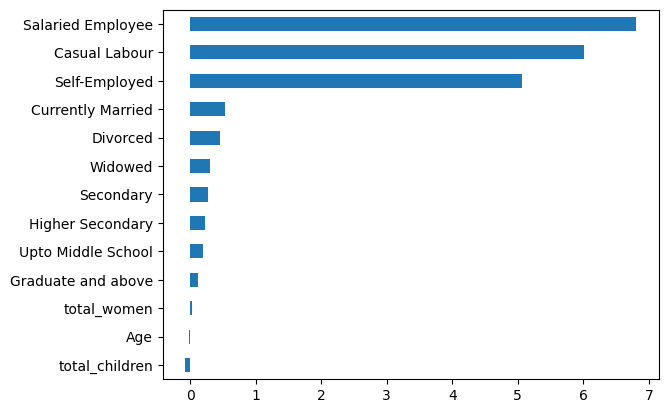

In [3]:
# Linear Regressions
# 1. Male, paid
print(male_X_paid.shape)


male_paid_lr = LinearRegression().fit(male_X_paid, male_y_paid)
print(male_paid_lr.score(male_X_paid, male_y_paid))

nonStateIx = ~male_X_paid.columns.isin(state_ohe.columns)

pd.Series(male_paid_lr.coef_[nonStateIx], index=male_paid_lr.feature_names_in_[nonStateIx]).sort_values().plot(kind='barh')

(192265, 49)
0.12375109212443136


<Axes: >

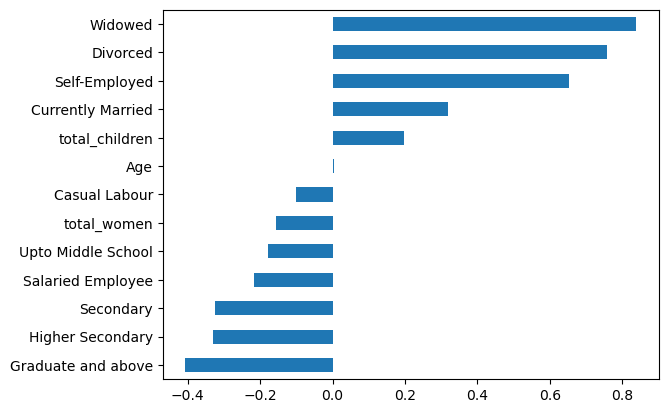

In [4]:
# Regressions
# 1. Male, unpaid
print(male_X_unpaid.shape)
male_unpaid_lr = LinearRegression().fit(male_X_unpaid, male_y_unpaid)
print(male_unpaid_lr.score(male_X_unpaid, male_y_unpaid))
pd.Series(male_unpaid_lr.coef_[nonStateIx], index=male_unpaid_lr.feature_names_in_[nonStateIx]).sort_values().plot(kind='barh')

(189851, 49)
0.5279792307718574


<Axes: >

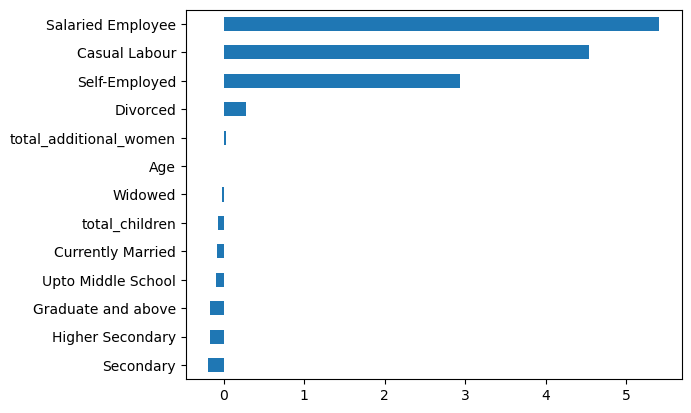

In [5]:
# Regressions
# 1. Female, paid
print(female_X_paid.shape)
female_paid_lr = LinearRegression().fit(female_X_paid, female_y_paid)
print(female_paid_lr.score(female_X_paid, female_y_paid))
pd.Series(female_paid_lr.coef_[nonStateIx], index=female_paid_lr.feature_names_in_[nonStateIx]).sort_values().plot(kind='barh')

(189851, 49)
0.43100128429001305


<Axes: >

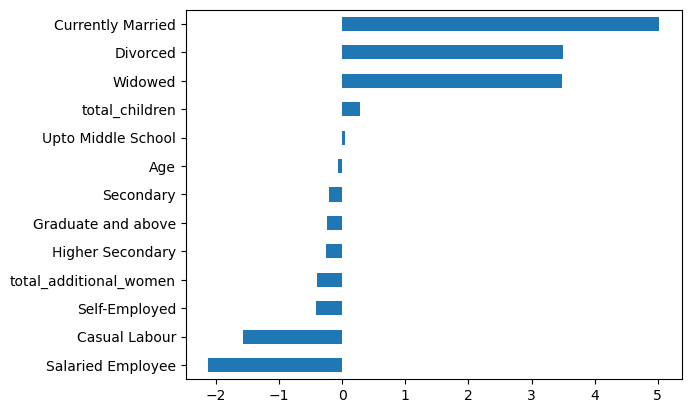

In [6]:
# Regressions
# 1. Female, unpaid
print(female_X_unpaid.shape)
female_unpaid_lr = LinearRegression().fit(female_X_unpaid, female_y_unpaid)
print(female_unpaid_lr.score(female_X_unpaid, female_y_unpaid))
pd.Series(female_unpaid_lr.coef_[nonStateIx], index=female_unpaid_lr.feature_names_in_[nonStateIx]).sort_values().plot(kind='barh')

---

# Decision Trees - Eqn 1

(192265, 49)
0.7366017477631553


<Axes: >

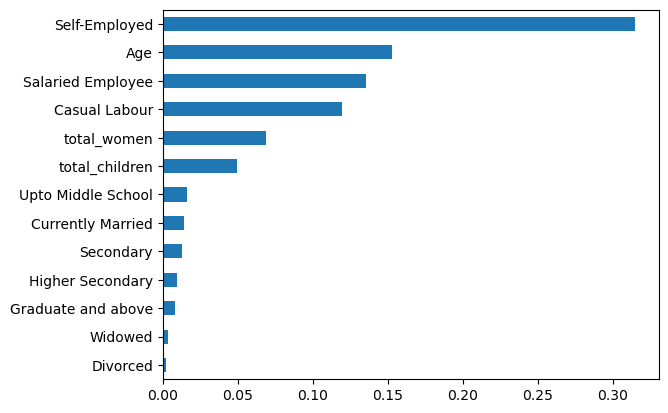

In [7]:
print(male_X_paid.shape)
male_paid_tree = DecisionTreeRegressor().fit(male_X_paid, male_y_paid)
print(male_paid_tree.score(male_X_paid, male_y_paid))
pd.Series(male_paid_tree.feature_importances_[nonStateIx], index=male_paid_tree.feature_names_in_[nonStateIx]).sort_values().plot(kind='barh')

(192265, 49)
0.5977746728624358


<Axes: >

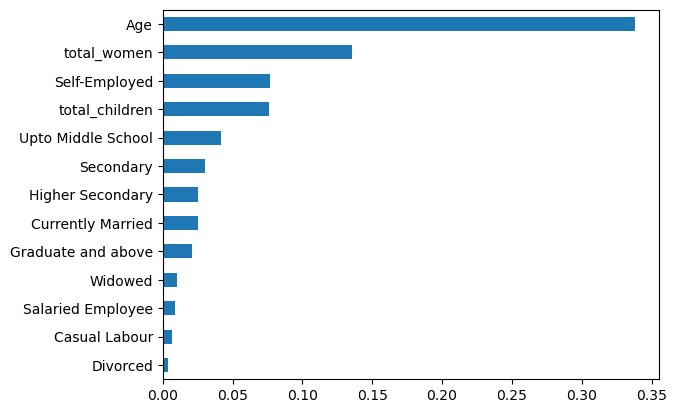

In [8]:
print(male_X_unpaid.shape)
male_unpaid_tree = DecisionTreeRegressor().fit(male_X_unpaid, male_y_unpaid)
print(male_unpaid_tree.score(male_X_unpaid, male_y_unpaid))
pd.Series(male_unpaid_tree.feature_importances_[nonStateIx], index=male_unpaid_tree.feature_names_in_[nonStateIx]).sort_values().plot(kind='barh')

(189851, 49)
0.8184981606902791


<Axes: >

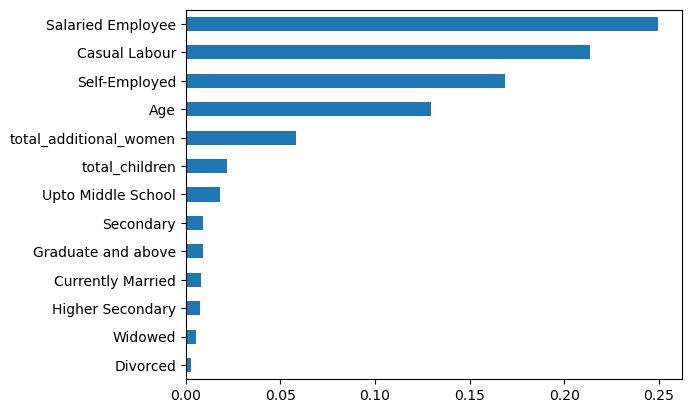

In [9]:
print(female_X_paid.shape)
female_paid_tree = DecisionTreeRegressor().fit(female_X_paid, female_y_paid)
print(female_paid_tree.score(female_X_paid, female_y_paid))
pd.Series(female_paid_tree.feature_importances_[nonStateIx], index=female_paid_tree.feature_names_in_[nonStateIx]).sort_values().plot(kind='barh')

(189851, 49)
0.7332461376240378


<Axes: >

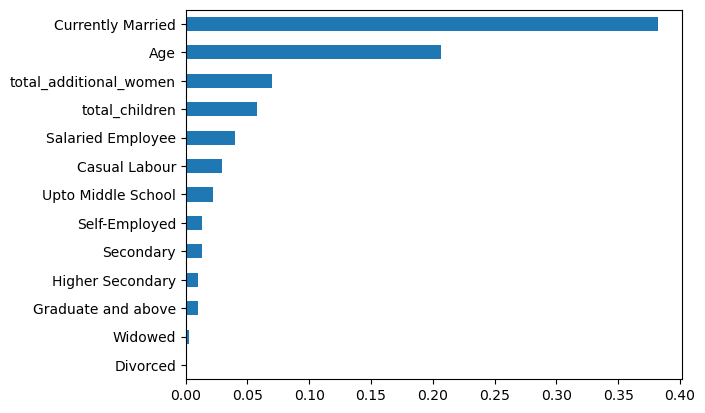

In [10]:
print(female_X_unpaid.shape)
female_unpaid_tree = DecisionTreeRegressor().fit(female_X_unpaid, female_y_unpaid)
print(female_unpaid_tree.score(female_X_unpaid, female_y_unpaid))
pd.Series(female_unpaid_tree.feature_importances_[nonStateIx], index=female_unpaid_tree.feature_names_in_[nonStateIx]).sort_values().plot(kind='barh')

---

# Eqn 3:

In [11]:
# Outputs: paid time, unpaid time, leisure, cooking, cleaning, collecting firewood, washing clothes, domestic chores, care work
# Features: social group, religion, sector, MPCE qrt, age, education, marital status, employment
# HH Features: piped gas, electricity, washing type, sweeping type, children (below and above 6 years), adult pwd, unemployed working age men

In [12]:
fX = df[df['Age'] >= 15].copy()
fX = fX[fX['Gender'] == 'Female']

# features
social_ohe = pd.get_dummies(fX.pop('Social_group_'), dtype=int, drop_first=True)
religion_ohe = pd.get_dummies(fX.pop('religion'), dtype=int, drop_first=True)

fX['sector'].replace({1.0: 'Rural', 2.0: 'Urban'}, inplace=True)
fX['sector'] = fX['sector'].astype('category').cat.reorder_categories(['Rural', 'Urban'], ordered=True)
sector_ohe = pd.get_dummies(fX.pop('sector'), dtype=int, drop_first=True)

mpce_ohe = pd.get_dummies(fX.pop('MPCE_qrt'), dtype=int, drop_first=True)
education_ohe = pd.get_dummies(fX.pop('education'), dtype=int, drop_first=True)

ms_enc = {1: 'Never Married', 2: 'Currently Married', 3: 'Widowed', 4: 'Divorced'}
fX['marital_status'] = fX['marital_status'].replace(ms_enc).astype('category')
fX['marital_status'] = fX['marital_status'].cat.reorder_categories(
    ['Never Married', 'Currently Married', 'Widowed', 'Divorced'], ordered=True
)
marital_status_ohe = pd.get_dummies(fX.pop('marital_status'), dtype=int, drop_first=True)
emp_ohe = pd.get_dummies(fX.pop('employment'), dtype=int, drop_first=True)
state_ohe = pd.get_dummies(fX.pop('state_codes'), dtype=int)

# Household composition
piped_gas = pd.get_dummies(fX.pop('piped_gas'), dtype=int, drop_first=True)
wired_source = pd.get_dummies(fX.pop('wired_source'), dtype=int, drop_first=True)
washing_type = pd.get_dummies(fX.pop('washing_type'), dtype=int, prefix='washing')
sweeping_type = pd.get_dummies(fX.pop('sweeeping_type'), dtype=int, prefix='sweeping')
child = pd.get_dummies(fX.pop('child'), dtype=int, drop_first=True)
adult_pwd = pd.get_dummies(fX.pop('old'), dtype=int, drop_first=True)
unemp_men = fX.pop('n_unemp_men')


target_cols = ['paid_activity_time', 'unpaid_activity_time', 'leisure_time', 'cooking_time', 'cleaning_time', 'firewood_time', 'washing_time', 'hh_time', 'care_time']
featX = pd.concat([
    social_ohe,
    religion_ohe,
    sector_ohe,
    mpce_ohe,
    fX[['Age']],
    education_ohe,
    marital_status_ohe,
    emp_ohe,
    piped_gas,
    wired_source,
    washing_type,
    sweeping_type,
    child,
    adult_pwd,
    unemp_men,
    state_ohe], axis=1)

In [13]:
trees = {}
for col in target_cols:
    tree = DecisionTreeRegressor().fit(featX, fX[col] / 60)
    trees[col] = tree
    print(col, f"{tree.score(featX, fX[col] / 60):.2f}")

paid_activity_time 0.96
unpaid_activity_time 0.93
leisure_time 0.88
cooking_time 0.91
cleaning_time 0.87
firewood_time 0.82
washing_time 0.87
hh_time 0.92
care_time 0.91


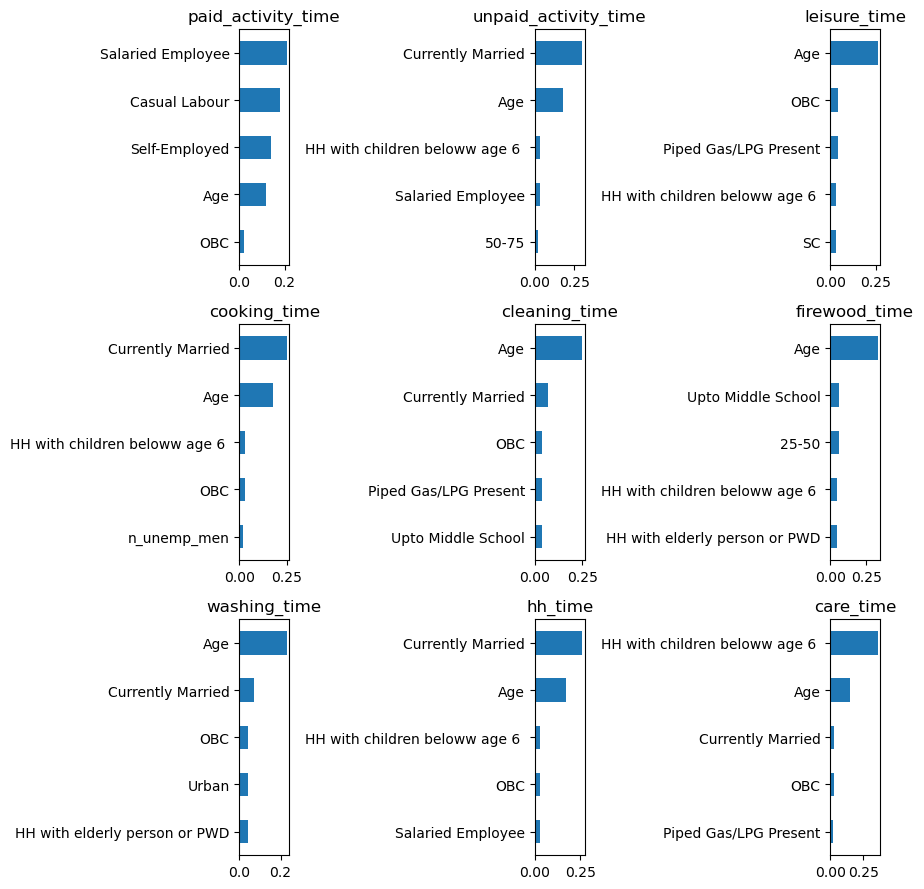

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))
ax = ax.ravel()
for i, col in enumerate(target_cols):
    tree = trees[col]
    nonStateIx = ~featX.columns.isin(state_ohe.columns)
    pd.Series(tree.feature_importances_[nonStateIx], index=tree.feature_names_in_[nonStateIx]).round(2).sort_values().tail(5).plot(kind='barh', ax=ax[i])
    ax[i].set_title(col)
plt.tight_layout()

---

## Explanations

In [15]:
from shap import TreeExplainer, summary_plot
from shap.plots import beeswarm

Text(0.5, 1.0, 'Male Paid Work')

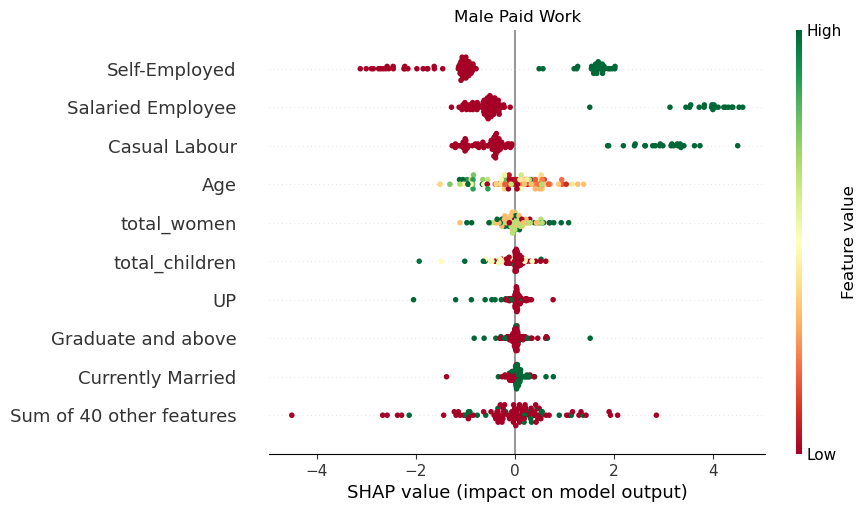

In [16]:
exp = TreeExplainer(male_paid_tree)
samples = male_X_paid.sample(100)
vals = exp(samples)
beeswarm(vals, color='RdYlGn', show=False)
ax = plt.gca()
ax.set_title('Male Paid Work')

Text(0.5, 1.0, 'Male Unpaid Work')

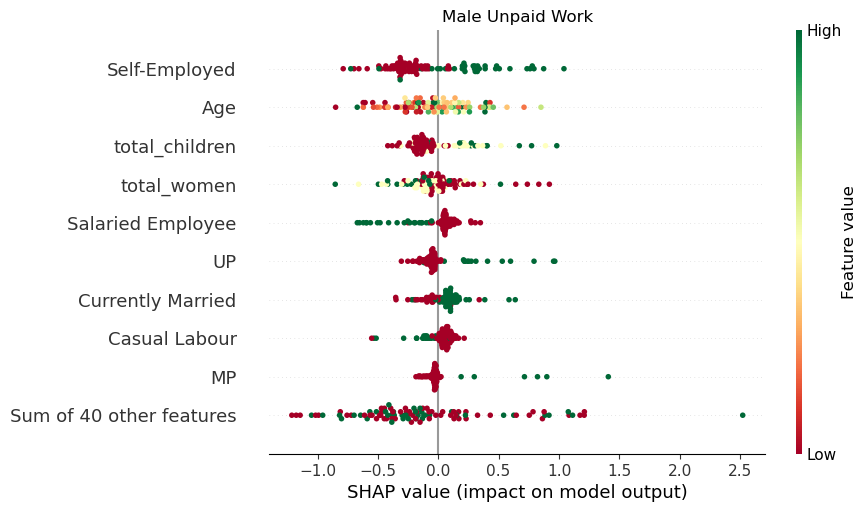

In [17]:
exp = TreeExplainer(male_unpaid_tree)
samples = male_X_unpaid.sample(100)
vals = exp(samples)
beeswarm(vals, color='RdYlGn', show=False)
ax = plt.gca()
ax.set_title('Male Unpaid Work')

Text(0.5, 1.0, 'Female Paid Work')

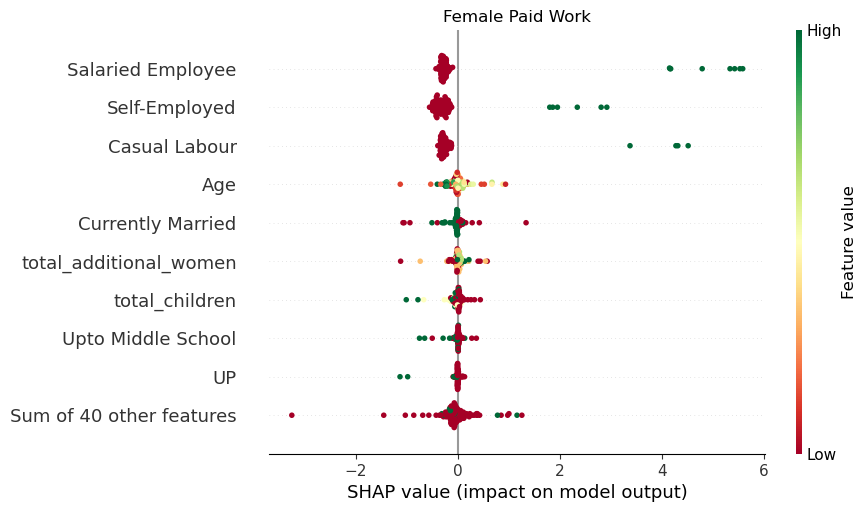

In [18]:
exp = TreeExplainer(female_paid_tree)
samples = female_X_paid.sample(100)
vals = exp(samples)
beeswarm(vals, color='RdYlGn', show=False)
ax = plt.gca()
ax.set_title('Female Paid Work')

Text(0.5, 1.0, 'Female Unpaid Work')

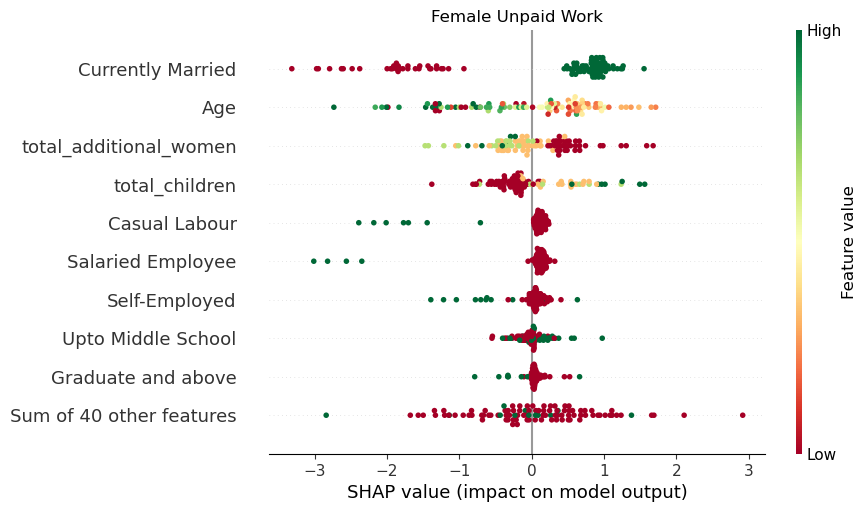

In [19]:
exp = TreeExplainer(female_unpaid_tree)
samples = female_X_unpaid.sample(100)
vals = exp(samples)
beeswarm(vals, color='RdYlGn', show=False)
ax = plt.gca()
ax.set_title('Female Unpaid Work')

In [20]:
# Beeswams of eqn3

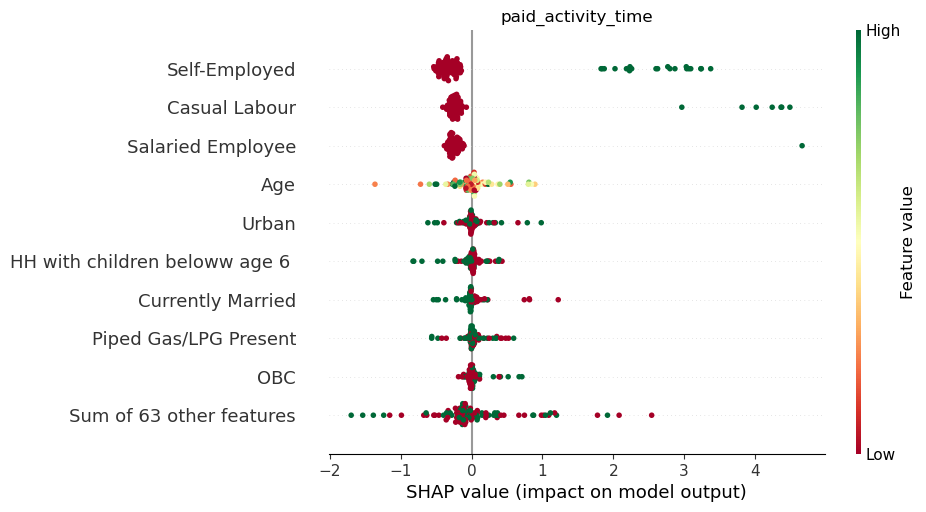

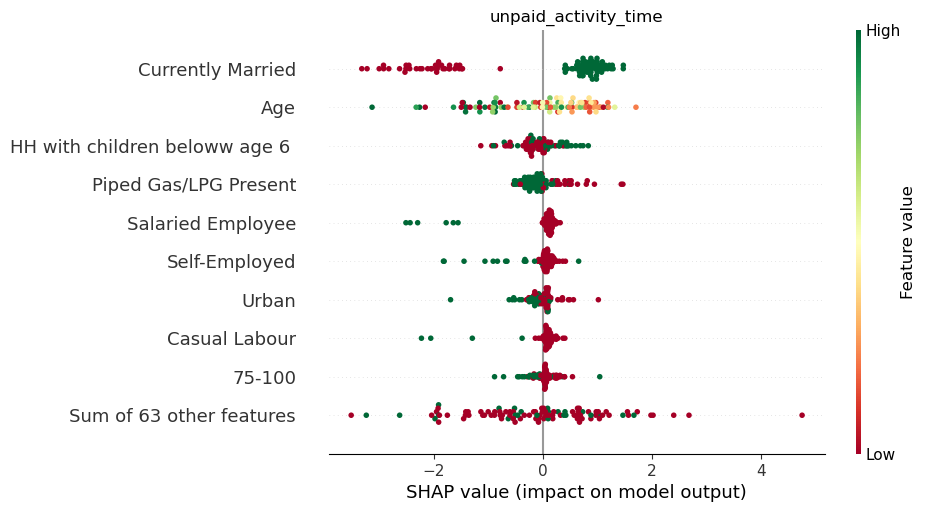

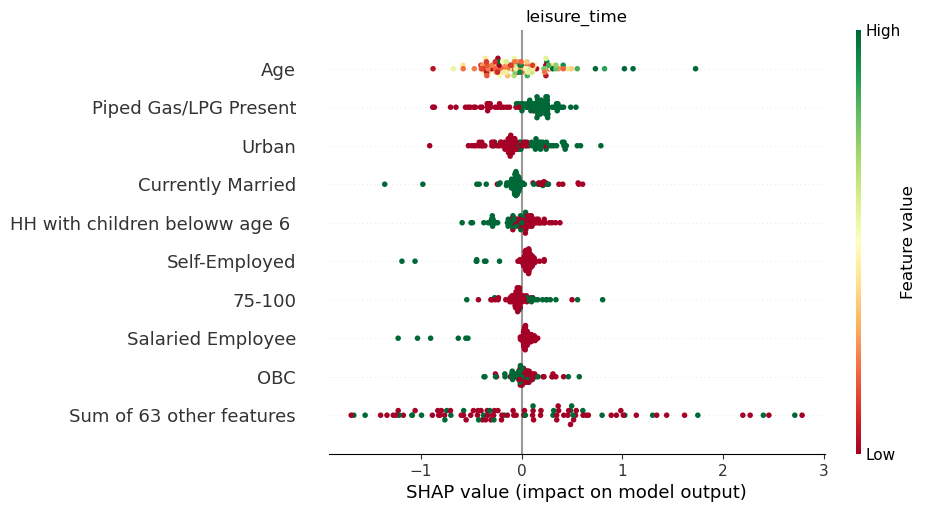

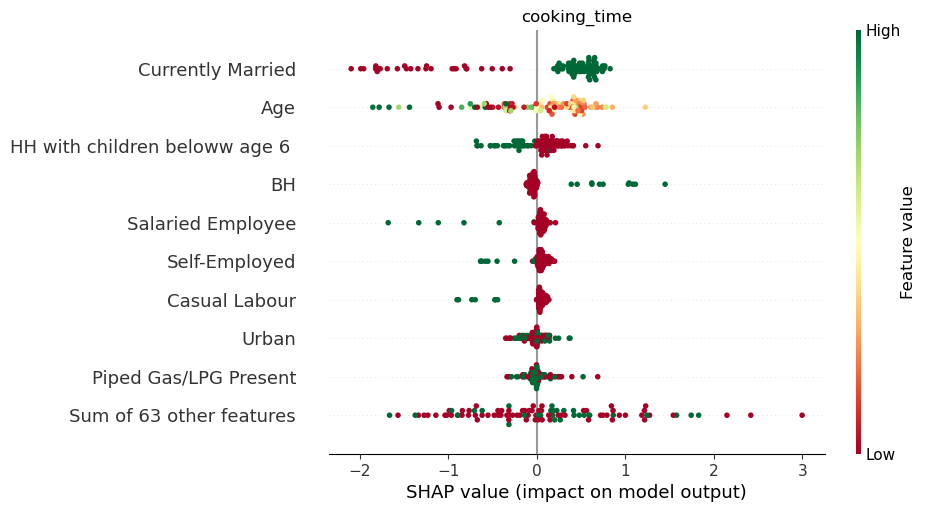

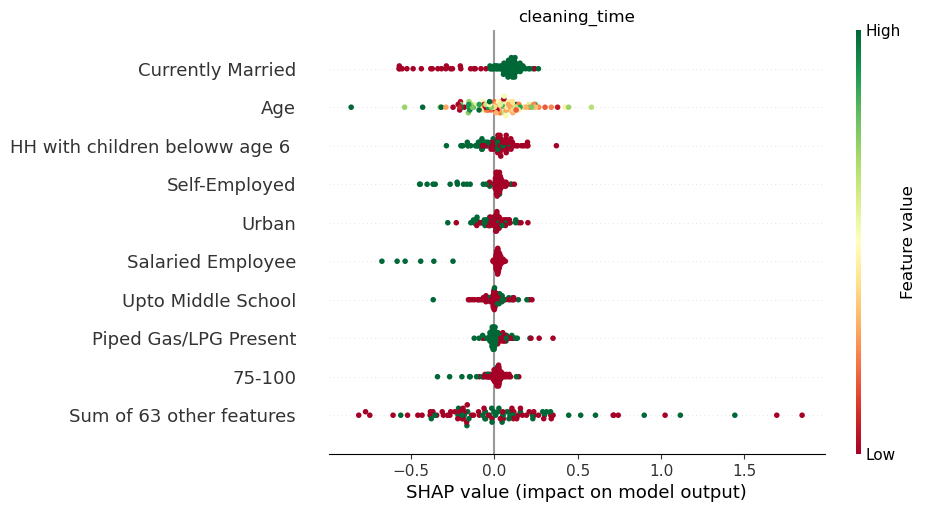

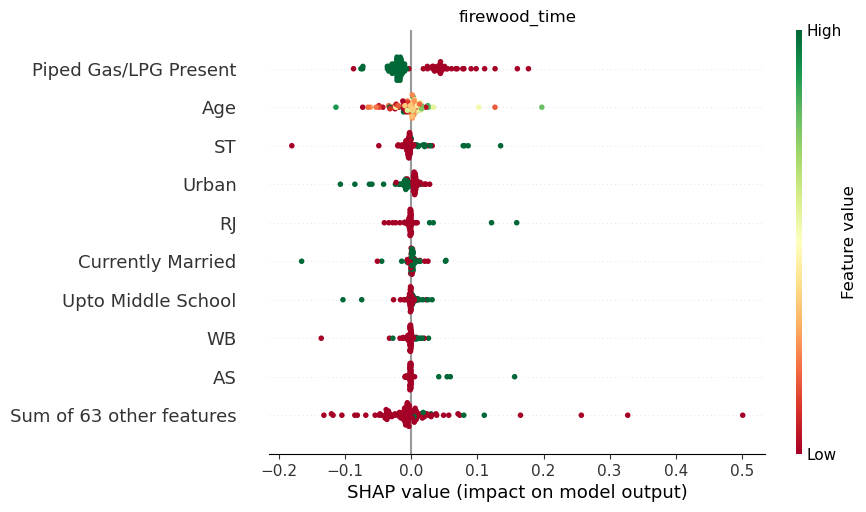

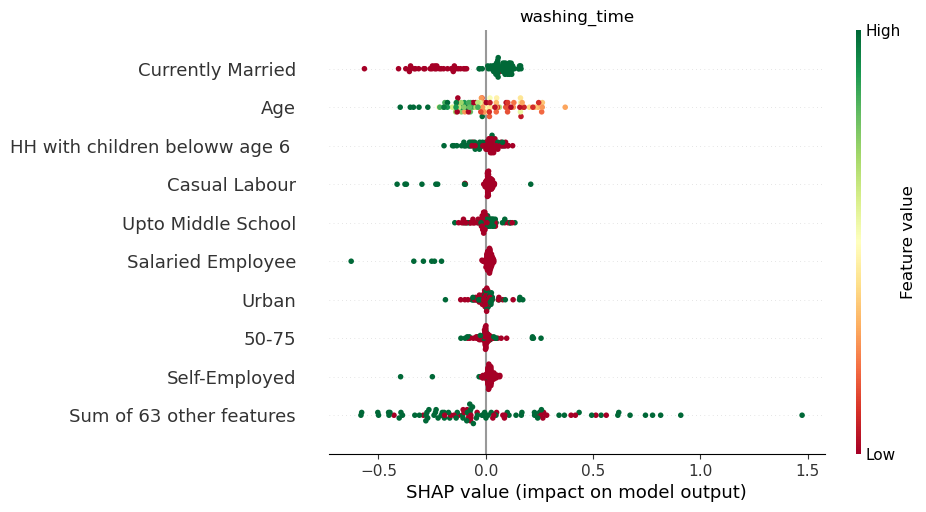

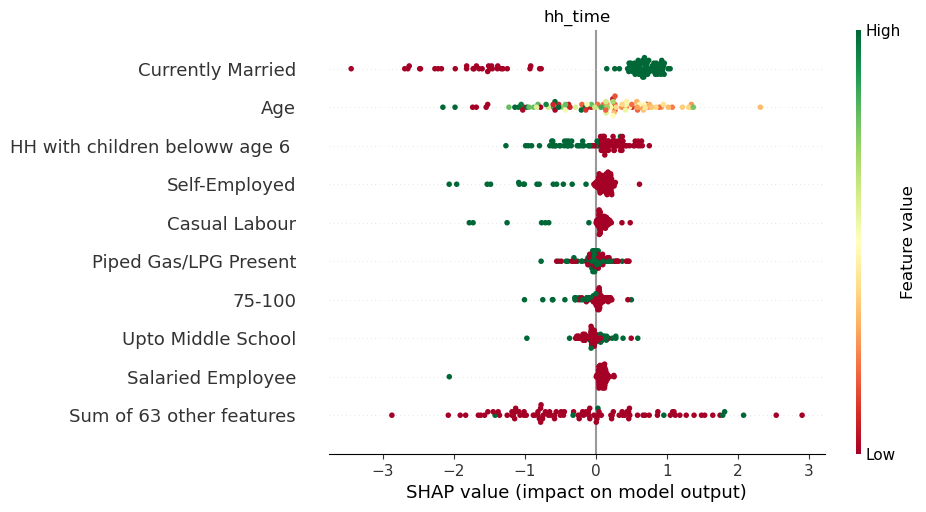

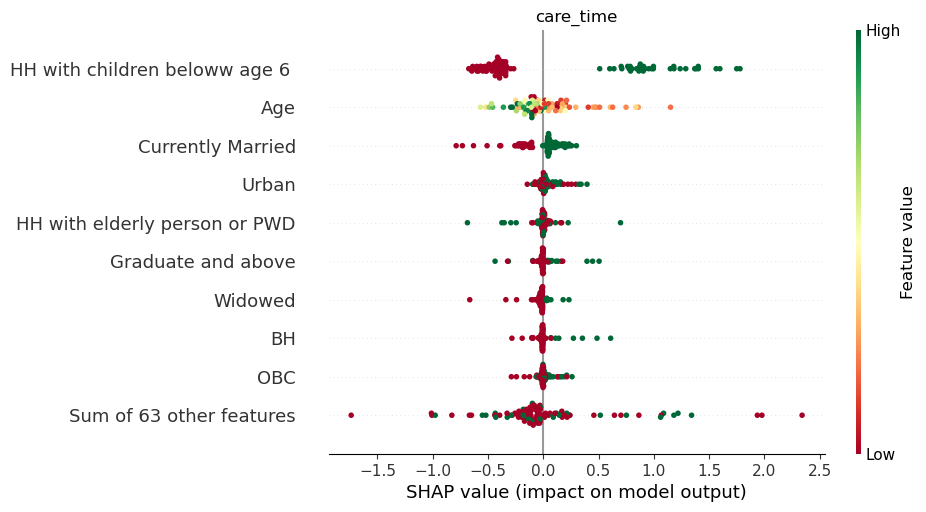

In [22]:
for col in target_cols:
    tree = trees[col]
    exp = TreeExplainer(tree)
    samples = featX.sample(100)
    vals = exp(samples)
    plt.figure()
    beeswarm(vals, color='RdYlGn', show=False)
    ax = plt.gca()
    ax.set_title(col)